In [1]:
# import necessary modules
import raadpy as rp
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

In [2]:
# Make the cmnd list a dictionary
# Node Port Message : Description, # in graph, # in cmnd list

CMND_LIST = {
"4"  : {"14": { "-1" : "Emergency Power-off of PAYLOAD if OBC reboots,-1,33"}},

"12" : { 
    "4": {"8": "Suspend Payload as well PMT,12,36",
          "1": "Load Scenario Suspended, PMT PAYLOAD,12,25",
          "2": "Load Scenario Awaken, PMT PAYLOAD,11,27",
          "4": "Reboot PMT Payload,13,29",
          },

    "8": {"0F": "After an Emergency Shutdown happened to PMT,3,34",
          "00": "Load Scenario 0 (Default) PMT PAYLOAD,0,1",
          "01": "Load Scenario 1 PMT PAYLOAD,1,2",
          "02": "Load Scenario 2 PMT PAYLOAD,2,3",
          "03": "Load Scenario 3 PMT PAYLOAD,3,4",
          "04": "Load Scenario 4 PMT PAYLOAD,4,5",
          "05": "Load Scenario 5 PMT PAYLOAD,5,6",
          "06": "Load Scenario 6 PMT PAYLOAD,6,7",
          "07": "Load Scenario 7 PMT PAYLOAD,7,8",
          "08": "Load Scenario 8 PMT PAYLOAD,8,9",
          "09": "Load Scenario 9 PMT PAYLOAD,9,10",
          "10": "Load Scenario 10 PMT PAYLOAD,10,11"
          },

    "9": {"0F": "Load CUSTOM Scenario PMT PAYLOAD,14,23"},

    "1": {"00": "Ping PMT PAYLOAD,15,31"}
    },

"13" : { 
    "4": {"8": "Suspend Payload as well SiPM,12,37",
          "1": "Load Scenario Suspended, SiPM PAYLOAD,12,26",
          "2": "Load Scenario Awaken, SiPM PAYLOAD,11,28",
          "4": "Reboot SiPM Payload,13,30",
          },

    "8": {"0F": "After an Emergency Shutdown happened to SiPM,3,35",
          "00": "Load Scenario 0 (Default) SiPM PAYLOAD,0,12",
          "01": "Load Scenario 1 SiPM PAYLOAD,1,13",
          "02": "Load Scenario 2 SiPM PAYLOAD,2,14",
          "03": "Load Scenario 3 SiPM PAYLOAD,3,15",
          "04": "Load Scenario 4 SiPM PAYLOAD,4,16",
          "05": "Load Scenario 5 SiPM PAYLOAD,5,17",
          "06": "Load Scenario 6 SiPM PAYLOAD,6,18",
          "07": "Load Scenario 7 SiPM PAYLOAD,7,19",
          "08": "Load Scenario 8 SiPM PAYLOAD,8,20",
          "09": "Load Scenario 9 SiPM PAYLOAD,9,21",
          "10": "Load Scenario 10 SiPM PAYLOAD,10,22"
          },

    "9": {"0F": "Load CUSTOM Scenario SiPM PAYLOAD,14,24"},

    "1": {"00": "Ping SiPM PAYLOAD,15,32"}

}}

In [3]:
# The Old Code:

# def log_line_timestamp(logline:list,time:float=0):
#     """Given a log file line as the lines decoded by log_expand, and a time
#     return the time increment for this line

#     Args:
#         logline (list): The element of the decoded logfile corresponding to a line
#         time (float): The time up to now

#     Returns:
#         time (float): Time increment after the execution of the command
#     """

#     splt = logline['command'].split(' ')                # Split the cmnd line (logline[0]) by the spaces 
#     if "SE0>\n" not in splt[0]:                         # If the cmnd is not the end of the log file: 
        
#         if "read" in splt[1]:                           # If cmnd is read time
#             time = float (logline['output'][0].split(" ")[3])  # Replace time with the time read

#         if splt[1] == "delay":                          # If the cmnd is a delay
#             time = time + (float(splt[2])/1000)         # Add time delay to previous time

#         if splt[1] == "delayuntil":                     # If cmnd is delayuntil 
#             time = float(splt[2])                       # Replace time by new time

#         if "FAIL\n" in logline['output']:               # if it was a payload cmnd and it failed (there will be delays)
#             time = time + float(splt[4])/1000           # take the time a payload cmnd takes to be excuted 

#     return time

In [4]:
# printit = log_line_timestamp()

In [5]:
# modified 2022-10-17
def log_line_timestamp(logline:list,time:float=0):
    """Given a log file line as the lines decoded by log_expand, and a time
    return the time increment for this line

    Args:
        logline (list): The element of the decoded logfile corresponding to a line
        time (float): The time up to now

    Returns:
        time (float): Time increment after the execution of the command
    """

    splt = logline['command'].split(' ')                            # Split the cmnd line (logline[0]) by the spaces 
    if "SE0>\n" not in splt[0]:                                     # If the cmd is not the end of the log file: 

        if "read" in splt[1]:                                       # If cmd is read time
            if "FAIL\n" in logline['output']:                       # If read cmd failed, 
                time = time                                         # Assume no time delay
            else:                                                   # If the cmd didn't fail
                time = float (logline['output'][0].split(" ")[3])   # Replace time with the time read

        elif splt[1] == "delay":                                      # If the cmd is a delay
            if "FAIL\n" in logline['output']:                       # If delay cmd failed, assume no time delay
                time = time                                         # Assume no time delay
            else:                                                   # If the cmd didn't fail
                time = time + (float(splt[2])/1000)                 # Add time delay to previous time

        elif splt[1] == "delayuntil":                                 # If cmd is delayuntil 
            if "FAIL\n" in logline['output']:                       # If delayuntil cmd failed, assume no time delay
                time = time                                         # Assume no time delay
            else:                                                   # If the cmd didn't fail
                time = float(splt[2])                               # Replace time by new time

        elif "txrx" in splt[1]:                                       # If it's a normal payload cmd, not a time cmd
            if "FAIL\n" in logline['output']:                       # If it failed (there will be delays)
               time = time + float(splt[4])/1000                    # Take the time a payload cmd takes to be excuted 

    return time

# Now we can define an error correction pass

def find_closest(x,array):
    """Helper function that returns the two closest values to x in a list

    Args:
        x (numeric): The value to search for
        array (iterable): The list to search in

    Returns:
        (a,b) (tuple): The two values closest to x that can be found in the list. If x is in the list, b=x and a<b.
    """
    # Binary search
    s   = 0
    e   = len(array)-1
    mid = (s + e)//2
    prevmid = -float('inf')

    # Handle edge cases
    if x <= array[s]: return (-float('inf'),array[s])
    if x >= array[e]: return (array[e],float('inf'))

    # Flag that will update condition to exit
    found = False
    while prevmid != mid:
        if x == array[mid]: return (array[mid-1],array[mid])
        if x < array[mid]:  e = mid
        if x > array[mid]:  s = mid

        prevmid = mid
        mid     = (s+e)//2

    if (s==e): return (array[s],array[s+1])
    return (array[s],array[e])



def reorder_log(logfile:list):
    """Reorder a logfile based on it's timestamps

    Args:
        logfile (list): The logifile after having a timestamp field added

    Returns:
        logfile (list): Corrected logfile in time
    """

    # Get a list of timestamps
    timestamps = np.array([line['timestamp'] for line in logfile])

    # Get the indices where the time is not increasing
    idx_flip = np.where(timestamps[1:] - timestamps[:-1] < 0)[0] + 1

    # Get he indices of the rtc reads
    idx_read = np.append([0],[np.where('SE0>rtc read\n' == np.array([line['command'] for line in logfile]))[0]])

    # Add the difference to the regions of interest
    for i in idx_flip:
        # Calculate the time difference
        diff = logfile[i-1]['timestamp'] - logfile[i]['timestamp']
        
        # Find the closest two rtc read timestamps
        _, closest_rtc = find_closest(i,idx_read)

        # Correct the timestamps in this region
        while (logfile[closest_rtc-1]['timestamp'] - logfile[closest_rtc]['timestamp']) > 0:
            logfile[closest_rtc-1]['timestamp'] -= diff
            closest_rtc -= 1


    return logfile


In [6]:
def log_with_timestamp(logfile:list):                        
    """Given a log file from the function log_expand
    return a list of log lines with the time increment of each line

    Args:
        logfile (list): a list of cubesat commands

    Returns:
        log_timestamp_list (list): a list of cubesat commands, each command with its timestamp
    """
    log_timestamp_list=[]                               # List to be returned later (cmnd, output, timestamp)
    time = 0                                            # Set initial time to zero, this step will not be needed
    for logline in logfile:
        time = log_line_timestamp(logline,time)
        log_timestamp_list.append ({
            'command':      logline['command'],
            'output':       logline['output'],
            'timestamp':    time
        })

    return reorder_log(log_timestamp_list)




In [8]:
# call log file:
# logfile = rp.log_expand("../Data/Light-1/light1-2022-09-15/light1-2022-09-15-se-log.txt")
# logfile = rp.log_expand("../Data/Light-1/light1-2022-10-05/light1-2022-10-05-se-log.txt")
logfile = rp.log_expand("../Data/Light-1/light1-2022-10-09/light1-2022-10-09-se-log.txt",remove_comments=True)

# test function:
log = log_with_timestamp(logfile)
for i,line in enumerate(log[:-20]):
    print("%4i: %17.6f %50s %5s"%(i,line['timestamp'],line['command'][:-1],line['output'][-1][:-1]))

   0: 1665246600.000000                   SE0>script delayuntil 1665246600    OK
   1: 1665246600.000000                   SE0>csp txrx 4 14 600 000800201C    OK
   2: 1665246600.000000                   SE0>csp txrx 4 14 600 000A00341C    OK
   3: 1665246600.000000                   SE0>csp txrx 4 14 600 000700391C    OK
   4: 1665246600.006500                                       SE0>rtc read    OK
   5: 1665246600.006500                   SE0>csp txrx 4 14 600 0007010100    OK
   6: 1665246601.006500                              SE0>script delay 1000    OK
   7: 1665246601.006500                   SE0>csp txrx 4 14 600 000A010100    OK
   8: 1665246602.006500                              SE0>script delay 1000    OK
   9: 1665246602.006500                   SE0>csp txrx 4 14 600 0008010100    OK
  10: 1665246782.006500                            SE0>script delay 180000    OK
  11: 1665246785.006500                          SE0>csp txrx 12 8 3000 0F  FAIL
  12: 1665246788.006500     

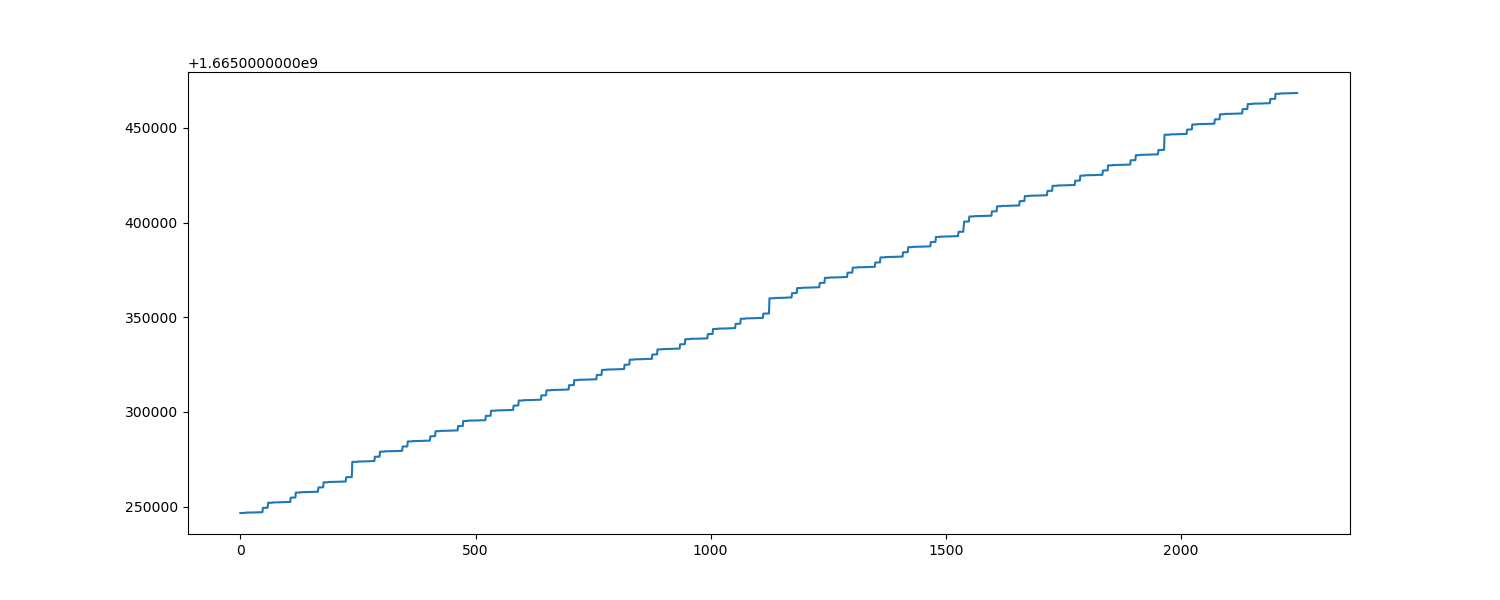

In [9]:
timestamps = np.array([line['timestamp'] for line in log])
fig = plt.figure(figsize=(15,6))
plt.plot(timestamps)
# Get the indices where the time is not increasing
idx = np.where(timestamps[1:] - timestamps[:-1] < 0)[0]

for i in idx:
    plt.axvline(i+1,lw=0.1)